In [1]:
# !conda install -c conda-forge tqdm -n TORCH_ENV_NAME
# !pip install torchinfo

import os
import sys
sys.path.append('lib')
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

import utils
from utils import STOCKS_LIST
from stock_data import stock_data
from RNN import RNN


# Pre-training

## Default values for training and testing

In [43]:
#* Name of stock
STOCKS = "GOOGL"
if STOCKS not in STOCKS_LIST:
    raise Exception("Given stocks col_name is not valid")

#* Set default precision
PRECISION = '32'
torch.set_default_dtype(getattr(torch, 'float' + PRECISION))

#* Whether to use pre-processed data
PRE_PROCESS = True

#* Recurrent Neural Network Type: Choosed between LSTM, GRU
RNN_TYPE = "LSTM"

#* prefix of model name: Full information of model
PREFIX = '_'.join([STOCKS, PRECISION, RNN_TYPE]) + "_"

#* Features to use: Choose between 'Open', 'Close', 'High', 'Low'
IN_FEATURES = ['Open', 'Close', 'High', 'Low']
OUT_FEATURES = ['High', 'Low']
IN_FEATURES, OUT_FEATURES = utils.check_features(IN_FEATURES, OUT_FEATURES)

PREFIX += ''.join([feature[0] for feature in IN_FEATURES]) + '2' + ''.join([feature[0] for feature in OUT_FEATURES])

#* Hidden size of LSTM/GRU
HIDDEN_SIZE = 50
if HIDDEN_SIZE != 50:
    PREFIX += "_HS{}".format(HIDDEN_SIZE)

#* Number of stacked layers of LSTM/GRU
NUM_LAYERS = 5
if NUM_LAYERS != 4:
    PREFIX += "_NL{}".format(NUM_LAYERS)

#* Drop out
DROPOUT = 0.3
if DROPOUT != 0.2:
    PREFIX += "_DO{:.2f}".format(DROPOUT)

#* Number of days to use prediction
PAST_DAYS = 100
if PAST_DAYS != 60:
    PREFIX += "_PD{}".format(PAST_DAYS)

#* Number of days to predict
SUCCESSIVE_DAYS = 14
if SUCCESSIVE_DAYS > 1:
    PREFIX += "_SD{}".format(SUCCESSIVE_DAYS)

#* Optimizer name
OPTIMIZER_NAME = 'RMSprop'
if OPTIMIZER_NAME != 'RMSprop':
    PREFIX += '_OP' + OPTIMIZER_NAME

#* Learning rate for optimizer
LEARNING_RATE = 1e-4
if LEARNING_RATE != 1e-3:
    PREFIX += "_LR{}".format(LEARNING_RATE)

#* Regularization for optimizer
L2_REGULARIZATION = 2e-4
if L2_REGULARIZATION:
    PREFIX += "_RG{}".format(L2_REGULARIZATION)

#* Scaler
SCALER_NAME = 'MinMaxScaler'
if SCALER_NAME != 'MinMaxScaler':
    PREFIX += '_' + SCALER_NAME

print("prefix:", PREFIX)

#* Check device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEVICE


prefix: GOOGL_32_LSTM_OHLC2HL_NL5_DO0.30_PD100_SD14_LR0.0001_RG0.0002


device(type='cuda', index=0)

## Generate dataset

In [44]:
data = stock_data(STOCKS, in_features=IN_FEATURES,
                  out_features=OUT_FEATURES,
                  past_days=PAST_DAYS,
                  scaler_name=SCALER_NAME,
                  precision=PRECISION,
                  pre_process=PRE_PROCESS,
                  successive_days=SUCCESSIVE_DAYS,
                  verbose=True)
train_loader = data.get_train_loader(batch_size=64, num_workers=4)
val_loader = data.get_val_loader(batch_size=64)


Finished reading a file data/pre_32/GOOGL.parquet.snappy
-----------------------------
Number of train set: 1899 with input: torch.Size([100, 4]) output: torch.Size([14, 2])
Number of validation set: 491 with input: torch.Size([100, 4]) output: torch.Size([14, 2])
Number of test set: 490 with input: torch.Size([100, 4]) output: torch.Size([14, 2])


## Define neural network, loss function, optimizer type

In [48]:
model = RNN(rnn_type=RNN_TYPE,
            in_features=IN_FEATURES,
            out_features=OUT_FEATURES,
            successive_days=SUCCESSIVE_DAYS,
            hidden_size=HIDDEN_SIZE,
            dropout=DROPOUT).to(DEVICE)
epoch = 0
train_loss_list, val_loss_list = np.array([]), np.array([])
optimizer = getattr(optim, OPTIMIZER_NAME)(params=model.parameters(),
                                           lr=LEARNING_RATE,
                                           weight_decay=L2_REGULARIZATION)
loss_func = nn.MSELoss()
utils.model_summary(model, input_size=(PAST_DAYS, len(IN_FEATURES)), precision=PRECISION)


Layer (type:depth-idx)                   Input Shape      Output Shape     Kernel Shape     Param #          Mult-Adds
├─LSTM: 1-1                              [1, 100, 4]      [1, 100, 50]     --               72,400           7,080,000
|    └─weight_ih_l0                                                        [200, 4]
|    └─weight_hh_l0                                                        [200, 50]
|    └─weight_ih_l1                                                        [200, 50]
|    └─weight_hh_l1                                                        [200, 50]
|    └─weight_ih_l2                                                        [200, 50]
|    └─weight_hh_l2                                                        [200, 50]
|    └─weight_ih_l3                                                        [200, 50]
|    └─weight_hh_l3                                                        [200, 50]
├─Linear: 1-2                            [1, 50]          [1, 28]          [50, 28]

## Load model if needed

In [64]:
#* Load model
epoch = 150

checkpoint = torch.load(os.path.join('model', PREFIX + '_{}.pth'.format(epoch)), map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_func = checkpoint['loss']
train_loss_list = checkpoint['train_loss_list']
val_loss_list = checkpoint['val_loss_list']
test_loss = checkpoint['test_loss']
print("Loaded model has average test loss: {:.6f}, recurrent test loss: {:.6f}".format(test_loss[0], test_loss[1]))

try:
    print("REMARK:", checkpoint['Remark'])
except NameError:
    pass


Loaded model has average test loss: 0.005580, recurrent test loss: 0.004144
REMARK: Need more training


# Training

In [65]:
train_epoch = 50
epoch += train_epoch
new_train_loss_list, new_val_loss_list = utils.train(model,
                                                     max_epoch=train_epoch,
                                                     loss_func=loss_func,
                                                     optimizer=optimizer,
                                                     train_loader=train_loader,
                                                     val_loader=val_loader,
                                                     verbose=False)
train_loss_list = np.concatenate((train_loss_list, new_train_loss_list))
val_loss_list = np.concatenate((val_loss_list, new_val_loss_list))



Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Train finished with 76.767698 seconds


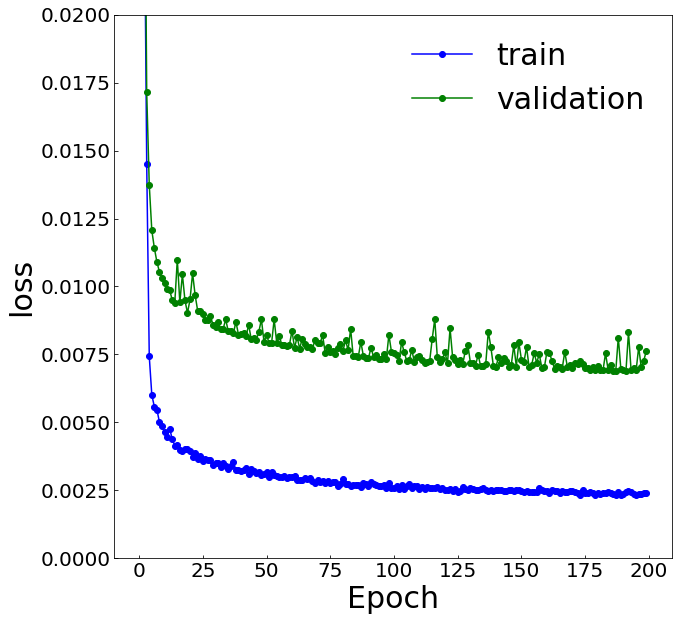

In [66]:
ax = utils.plot_loss(train_loss_list, val_loss_list)
_ = ax.set_ylim([0, 0.02])

# Test

Average test finished with 1.59 seconds
Loss: 0.005262
Recurrent test finished with 1.58 seconds
Loss: 0.003808


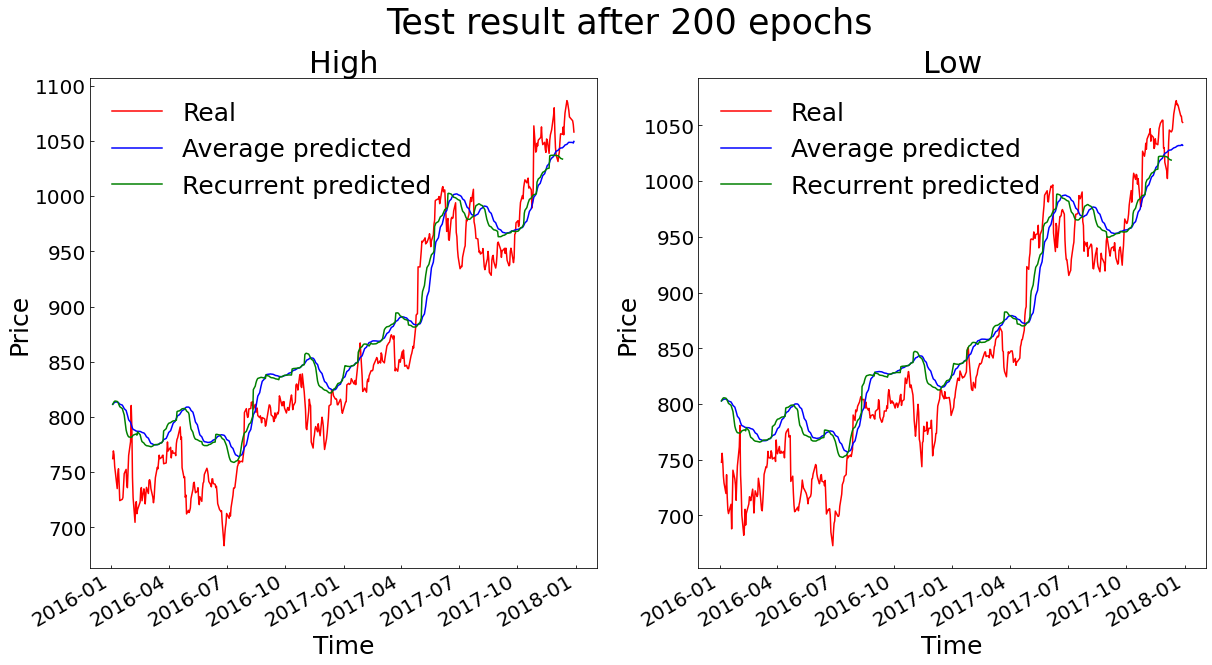

In [67]:
avg_prediction, avg_test_loss = utils.average_test(model, data,
                                                   loss_func=loss_func,
                                                   verbose=True)
recurrent_prediction, recurrent_test_loss = utils.recurrent_test(model, data,
                                                                 loss_func=loss_func,
                                                                 verbose=True)

ax = utils.plot_prediction(data=data,
                           epoch=epoch,
                           #   save_path=os.path.join('fig', PREFIX + "_prediction.png"),
                           avg_prediction=avg_prediction,
                           recurrent_prediction=recurrent_prediction)


# Save the model

In [68]:
#* Save the model with current state
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_func,
            'train_loss_list': train_loss_list,
            'val_loss_list': val_loss_list,
            'Remark': 'Finished training',
            'test_loss': (avg_test_loss, recurrent_test_loss)},
           os.path.join('model', PREFIX + '_{}.pth'.format(epoch)))